In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: Numba needs NumPy 1.21 or less

In [ ]:
adata = mb.bindome.datasets.scATAC.PBMCs_10x_v2(datadir='../../atac_poisson_study/data/')
peak_ids = adata.var_names

In [ ]:
# get sequences

In [9]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - 100
adata.var['summit.end'] = adata.var['summit'] + 100


In [10]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [11]:
import os

In [12]:
gen_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'hg38', 'genome', 'hg38.fa')

In [13]:
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']], genome='hg38', uppercase=True,
                                           gen_path=gen_path)
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmpk9cw79vm
genome hg38 False
/mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
bedtools getfasta -fi /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmpk9cw79vm -fo /tmp/tmp7ek9t7dd


WARNING. chromosome (KI270727.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chr

In [20]:
adata.shape

(10246, 165376)

In [21]:
seqs[0]

['chr1:10116-10316',
 'CCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAAACCCTAAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCAACCCCAACCCCAACCCCAACCCCA']

In [22]:
# remove Ns
seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [23]:
next_data = pd.DataFrame.sparse.from_spmatrix(counts)


In [24]:
next_data['seq'] = [s[1] for s in seqs]

In [25]:
next_data

,0,1,2,3,4,5,6,7,8,9,...,10237,10238,10239,10240,10241,10242,10243,10244,10245,seq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCC...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACAACCCTAACCCTAACCCTAACAACCCTAACCCTAACCCTAACCC...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CGCAGAGAGGCGCGCCGCGCCGGCGCAGGCGCAGAGACACATGCTA...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACTGGGGCCTGAGCTGCGTGGTGGGGAGAGAGTCTCTCCCCTGCCC...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CTTCTGAAAGGGTTGCTTGACCCACAGATGTGAAGCTGAGGCTGAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GACGCCATCCAGAGCTTACAGCTCAGGCCTCCTGCCCTGAGACTAG...
165372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GGGTCCGTGCTGAGGAGAACACTGCTCTGCCTTCCCTGTATCTCCG...
165373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTGGAGTGGAGTGGAATGGGGGATAATGGAGTGGAGTAGAGTGGAG...
165374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GAATCGAATGGAAGGGAATGAAATTGAATCAACACGAATGGAAGGG...


In [26]:
print('here...')

here...


In [27]:
# next_data = next_data.head(10000)
next_data = next_data.reindex(next_data[next_data.columns[:-1]].sum(axis=1).sort_values(ascending=False).index).reset_index(drop=True)

/tmp/ipykernel_23462/125132473.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  next_data_sel.sum(axis=1)
/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/encoding.py:9: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "onehot_mononuc" failed type inference due to: non-precise type pyobject
During: typing of argument at /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/encoding.py (11)

File "../multibind/tl/encoding.py", line 11:
def onehot_mononuc(seq, label_encoder=LabelEncoder(), onehot_encoder=OneHotEncoder(sparse=False)):
    seq_arr = np.array(list(seq + 'ACGNT'))
    ^

  @jit
/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "

next seqlen 12
Dinuc features not implemented yet. Using only mononuc features.
kernel to optimize 0
Epoch:  1, Loss: 0.465
before shift optim.


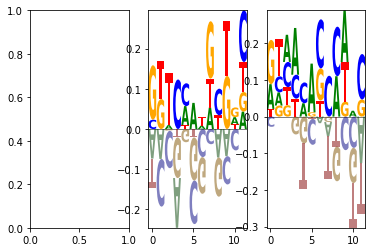

after shift optimz model


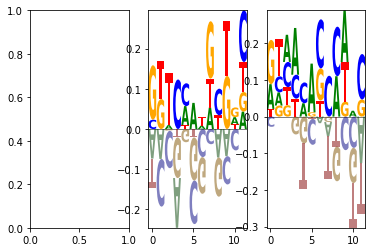


kernel to optimize 1
Epoch:  1, Loss: 0.379
before shift optim.


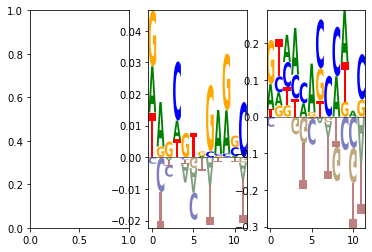

optimize_motif_shift (once)...0.3785621681287894 0.3715838901388262 0.3730770216519379
optimize_motif_shift (again)...0.3715838901388262 0.36828655370121516 0.37094557608007933
optimize_motif_shift (again)...0.36828655370121516 0.3748063084200534 0.3711007533181746
after shift optimz model


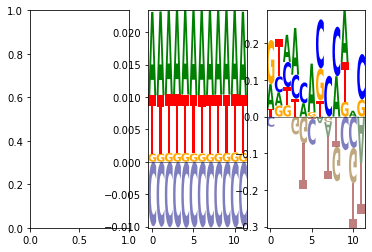


kernel to optimize 2
Epoch:  1, Loss: 0.384
before shift optim.


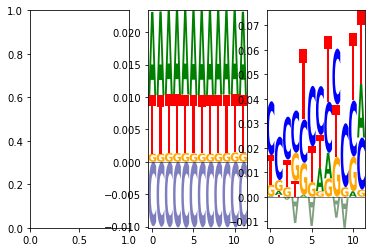

optimize_motif_shift (once)...0.3729166670563673 0.36974169559043923 0.3723289465199173
optimize_motif_shift (again)...0.36974169559043923 0.37330643262335933 0.3764782804004343
after shift optimz model


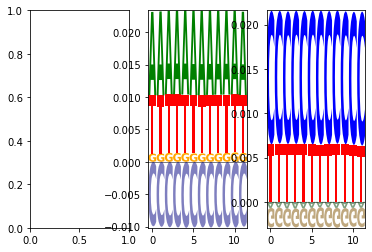

AssertionError: 

In [28]:
next_data_sel = next_data[[i for i in range(7)] + ['seq']]
next_data_sel = next_data_sel[next_data_sel[next_data_sel.columns[:-1]].sum(axis=1) > 10]
next_data_sel.shape
# for testing purposes
# next_data['seq'] = next_data['seq'].astype(str).str[:min(next_data['seq'].str.len())]
next_data_sel = next_data_sel[next_data_sel['seq'].str.len() == 200].reset_index(drop=True)
next_data_sel.sum(axis=1)
n_rounds = next_data_sel.shape[1] - 2
n_rounds
# # n_rounds
dataset = mb.datasets.SelexDataset(next_data_sel, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=100, shuffle=True)
# s = [mb.tl.onehot_mononuc(row['seq'], le, oe) for index, row in next_data.iterrows()]
# model = mb.models.DinucSelex(use_dinuc=True, kernels=[0] + [w] * (n_kernels - 1),  n_rounds=n_rounds).to(device)


import copy
model_by_k = {}
optimize_motif_shift = True
n_kernels = 3
num_epochs = 500
early_stopping = 5
log_each = 25
seqlen = list(next_data['seq'].str.len())[0]

for w in range(12, seqlen, 2):
    # step 1) freeze everything before the current binding mode
    print('next seqlen', w)
    model = mb.models.DinucSelex(use_dinuc=True, kernels=[0] + [w] * (n_kernels - 1), n_rounds=n_rounds,
                                 enr_series=False).to(device)

    for i in range(0, n_kernels):
        print('kernel to optimize %i' % i)

        for ki in range(n_kernels):
            mb.tl.update_grad(model, ki, ki == i)

        optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
        criterion = mb.tl.PoissonLoss()
        mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=num_epochs,
                            early_stopping=early_stopping, log_each=log_each)
        model.load_state_dict(model.best_model_state) # probably here load the state of the best epoch and save 
        k_parms = 'model_%i' % w
        model_by_k[k_parms] = copy.deepcopy(model) # store model parameters and fit for later visualization
        # optimizer for left / right flanks
        best_loss = model_by_k[k_parms].best_loss

        print('before shift optim.')
        mb.pl.conv_mono(model)

        #######
        # optimize the flanks through +1/-1 shifts
        #######
        if optimize_motif_shift and i != 0:
            next_loss = None
            while next_loss is None or next_loss < best_loss:
                print('optimize_motif_shift (%s)...' % ('once' if next_loss is None else 'again'), end='')
                model = model_by_k[k_parms]
                best_loss = model.best_loss

                model_left = mb.tl.train_shift(copy.deepcopy(model), train, kernel_i=i, shift=1,
                                               device=device, num_epochs=num_epochs,
                                               early_stopping=early_stopping, log_each=log_each,
                                               update_grad_i=i)
                model_right = mb.tl.train_shift(copy.deepcopy(model), train, kernel_i=i, shift=-1,
                                                device=device, num_epochs=num_epochs,
                                                early_stopping=early_stopping, log_each=log_each,
                                                update_grad_i=i)
                print(best_loss, model_left.best_loss, model_right.best_loss)
                best = sorted([[model, best_loss],
                               [model_left, model_left.best_loss],
                               [model_right, model_right.best_loss]], key= lambda x: x[-1])
                next_model, next_loss = best[0]
                model_by_k[k_parms] = copy.deepcopy(next_model)

        model = model_by_k[k_parms]
        n_feat = sum([np.prod(layer.kernel_size) for conv in [model.conv_mono, model.conv_di] for layer in conv if layer is not None])
        l_best = model.best_loss

        print('after shift optimz model')
        mb.pl.conv_mono(model_by_k[k_parms])
        print('')

    assert False

    r = [k_parms, w, n_feat, l_best]
    # print(r)
    res.append(r)
    print('')

In [29]:
print('here...')

here...


In [ ]:
from matplotlib import rcParams

In [ ]:
next_data_sel

In [ ]:
import seaborn as sns
rcParams['figure.figsize'] = 5, 3

activity = np.exp(model.log_activity.weight.cpu().detach().numpy())
rel_activity = activity / np.sum(activity)
sns.heatmap(rel_activity.T, cmap='Reds')
plt.title('rel contrib.')
plt.ylabel('selection round')
plt.xlabel('binding mode rel activity')
